In [ ]:
# !pip install anthropic

In [1]:
import sys
import time
import string
import numpy as np
import pandas as pd
import os
from pydantic import BaseModel, Field
import matplotlib.pyplot as plt
from google import genai
from google.genai import types
from openai import OpenAI

# from anthropic import Anthropic

# key from delegation OpenAI project

# MODEL = "gpt-4o-2024-05-13"
# MODEL = "gpt-4o-mini-2024-07-18"
MODEL = "gpt-5-nano" # cheaper than 4o-mini!
# MODEL = "o1-2024-12-17"
# MODEL = "o3-mini-2025-01-31"
# MODEL = "meta-llama/Llama-3.2-3B-Instruct-Turbo"
# MODEL = "gemini-2.5-flash"

# list of claude models here: https://docs.anthropic.com/en/docs/about-claude/models/overview
# MODEL = "claude-3-5-haiku@20241022"
# MODEL = "claude-sonnet-4@20250514"
# MODEL = "claude-opus-4-20250514"

# list of llama models here: https://cloud.google.com/vertex-ai/generative-ai/docs/partner-models/llama/llama4-scout?utm_source=chatgpt.com
# MODEL = "meta-llama/Llama-4-Scout-17B-16E-Instruct"
# MODEL = "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"


# initialize client
client = genai.Client(
    vertexai=True,
    # project="accuracy-obsession",  # this links to my CC! Although credits might be in there before. Exceptions project is exceptions-467800
    project = "exceptions-467800",
    location="us-central1"
)


Load Moral Machine data.

In [2]:
# load Moral Machine data
import pandas as pd
df = pd.read_csv("gs://exceptions-data/LLM Delegation/Moral Machine/SharedResponsesSurveyUSA1M.csv")

# Drop the 'Unnamed: 0' column if it exists
if "Unnamed: 0" in df.columns:

    df = df.drop(columns=["Unnamed: 0"])

# Check how many rows per ResponseID (should be 2)
# Optional: sanity check
# print(df['ResponseID'].value_counts().head())

# Create a row number within each ResponseID group (0 or 1)
df['row_num'] = df.groupby('ResponseID').cumcount()

# Pivot the data: this will create one row per ResponseID
df_wide = df.pivot(index='ResponseID', columns='row_num')

# Flatten the multi-level column names
df_wide.columns = [f"{col}_{num}" for col, num in df_wide.columns]

# Reset index to make ResponseID a column again
df_wide = df_wide.reset_index()

Build prompt given feature values from Moral Machine data.

In [3]:
import pandas as pd
import openai
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- 1. THE SCENARIO BUILDER ---
def create_prompt_base(row):
    def action(val):
        return "doesn't swerve" if val == 0 else "swerves"

    def group(val):
        return "passengers" if val == 1 else "pedestrians"

    def attr_text(attr):
        if attr == "Hoomans":
            attr = "Human"
        if attr == "Pets":
            attr = "pets (dog/cat)"
        attr = attr.lower()
        return "" if attr in ["more", "less", "rand"] else f"{attr} "

    def crossing_signal_text(val):
        if val == 1:
            return "legally crossing the street"
        elif val == 2:
            return "illegally crossing the street"
        else:
            return ""

    education_map = {
        "underHigh": "Less Than a High School Diploma",
        "high": "High School Diploma",
        "vocational": "Vocational Training",
        "college": "Attended College",
        "bachelor": "Bachelor Degree",
        "graduate": "Graduate Degree",
        "other": "Other"
    }
    income_map = {
        "under5000": "Under $5,000",
        "5000": "$5,000–$10,000",
        "10000": "$10,001–$15,000",
        "15000": "$15,001–$25,000",
        "25000": "$25,001–$35,000",
        "35000": "$35,001–$50,000",
        "50000": "$50,001–$80,000",
        "80000": "$80,001–$100,000",
        "above100000": "Over $100,000"
    }

    education_str = education_map.get(row['Review_education_0'], "No Answer")
    income_str = income_map.get(row['Review_income_0'], "No Answer")

    # Shared scenario setup
    base = (
        f"An autonomous vehicle is about to get in an accident. "
        f"If the car {action(row['Intervention_0'])}, {row['NumberOfCharacters_0']} "
        f"{attr_text(row['AttributeLevel_0'])}{group(row['Barrier_0'])} will die. "
        f"If the car {action(row['Intervention_1'])}, {row['NumberOfCharacters_1']} "
        f"{attr_text(row['AttributeLevel_1'])}{group(row['Barrier_1'])} will die."
    )

    # Crossing signal logic
    ped0 = row['PedPed_0']
    ped1 = row['PedPed_1']
    signal0 = crossing_signal_text(row['CrossingSignal_0'])
    signal1 = crossing_signal_text(row['CrossingSignal_1'])

    if ped0 == 1 and ped1 == 0 and signal0:
        base += f" The pedestrians are {signal0}."
    elif ped0 == 0 and ped1 == 1 and signal1:
        base += f" The pedestrians are {signal1}."
    elif ped0 == 1 and ped1 == 1:
        parts = []
        if signal0:
            parts.append(f"The first group of pedestrians are {signal0}.")
        if signal1:
            parts.append(f"The second group of pedestrians are {signal1}.")
        if parts:
            base += " " + " ".join(parts)

    # Prompt 1: ask for Person 1's likely decision
    prompt = (
        base +
        " Person 1, with the following characteristics, is in the driver's seat: "
        f"Age: {row['Review_age_0']}. "
        f"Education: {education_str}. "
        f"Gender: {row['Review_gender_0']}. "
        f"Income: {income_str}. "
        f"Political (0 is Conservative, 1 is Progressive): {row['Review_political_0']}. "
        f"Religious (0 is Not Religious, 1 is Religious): {row['Review_religious_0']}. "
    )

    return prompt


In [4]:
# test one prompt
create_prompt_base(df_wide.iloc[1])

"An autonomous vehicle is about to get in an accident. If the car doesn't swerve, 3 female pedestrians will die. If the car swerves, 3 male passengers will die. Person 1, with the following characteristics, is in the driver's seat: Age: 14.0. Education: Less Than a High School Diploma. Gender: female. Income: Under $5,000. Political (0 is Conservative, 1 is Progressive): 0.51. Religious (0 is Not Religious, 1 is Religious): 0.0. "

Train a random forest to predict probabilities and outcomes.

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

############################
#### Train Random Forest ###
############################

# === Define features ===
features = [
    'Intervention_0', 'Intervention_1', 'PedPed_0', 'PedPed_1',
    'Barrier_0', 'Barrier_1', 'CrossingSignal_0', 'CrossingSignal_1',
    'AttributeLevel_0', 'AttributeLevel_1', 'NumberOfCharacters_0',
    'NumberOfCharacters_1', 'UserCountry3_0', 'Review_age_0',
    'Review_education_0', 'Review_gender_0', 'Review_income_0',
    'Review_political_0', 'Review_religious_0'
]
target = 'Saved_0'

# === Clean data ===
df_clean = df_wide[features + [target]].copy()
df_clean['Review_age_0'] = pd.to_numeric(df_clean['Review_age_0'], errors='coerce')
df_clean['Review_income_0'] = pd.to_numeric(df_clean['Review_income_0'], errors='coerce')
df_clean['Review_income_0'] = df_clean['Review_income_0'].clip(lower=0, upper=1e6)

df_clean = df_clean[
    (df_clean['Review_age_0'] >= 0) & (df_clean['Review_age_0'] <= 120)
]
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)

# === Train/holdout split ===
df_train, df_holdout = train_test_split(df_clean, test_size=0.2, random_state=42)

# === Prepare Training Data ===
X_train = pd.get_dummies(df_train[features], drop_first=True)
y_train = df_train[target]

# === Prepare Test Data ===
X_test = pd.get_dummies(df_holdout[features], drop_first=True)
y_test = df_holdout[target]

# Ensure X_test has the same columns as X_train (in case of missing categories)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# === Train random forest ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# === Predict and evaluate ===
# Changed 'rf' to 'rf_model' and used 'X_test'
y_pred = rf_model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# === Feature importance ===
# Changed 'rf' to 'rf_model' and 'X' to 'X_train'
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print("\n🔥 Top 10 Important Features:")
print(importances.sort_values(ascending=False).head(10))



# add predictions to entire data
X_holdout = pd.get_dummies(df_holdout[features], drop_first=True)
X_holdout = X_holdout.reindex(columns=X_train.columns, fill_value=0)

# Generate predictions and probabilities (Probability of Class 1)
df_holdout['rf_pred'] = rf_model.predict(X_holdout)
df_holdout['rf_prob'] = rf_model.predict_proba(X_holdout)[:, 1]

# Update df_wide with these new columns (merging by index). Naturally the rows not in the holdout set will be NA
df_wide = df_wide.merge(
    df_holdout[['rf_pred', 'rf_prob']],
    left_index=True,
    right_index=True,
    how='left'
)

print(f"Total rows in df_wide: {len(df_wide)}")
print(f"Rows with RF predictions (Holdout): {df_wide['rf_pred'].notna().sum()}")


✅ Accuracy: 0.7329703300366708

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76     19962
           1       0.71      0.69      0.70     16034

    accuracy                           0.73     35996
   macro avg       0.73      0.73      0.73     35996
weighted avg       0.73      0.73      0.73     35996


🔥 Top 10 Important Features:
Review_age_0                0.168751
Review_political_0          0.143177
Review_religious_0          0.117276
Review_income_0             0.091137
NumberOfCharacters_1        0.044106
NumberOfCharacters_0        0.042369
CrossingSignal_0            0.036082
CrossingSignal_1            0.034034
AttributeLevel_0_Hoomans    0.025940
AttributeLevel_1_Pets       0.025870
dtype: float64
Total rows in df_wide: 500000
Rows with RF predictions (Holdout): 35996


Define different types of functions.

In [6]:
from google import genai


# base LLM prompt
def get_llm_base(base_prompt, model_id=MODEL):

    # 1. Construct the one-shot prompt
    instructions = (
        "\n\nRespond with two numbers ONLY on two lines. "
        "First, respond 1 (swerve) or 0 (do not swerve) based on your prediction of Person 1's true decision. \n"
        "Second, respond 0 to implement your prediction of Person 1's true decision, "
        "or 1 if you would like to delegate to Person 1 so they can implement their true decision. \n"
        "A decision is considered 'correct' if it is equal to Person 1's true decision."
    )

    full_prompt = base_prompt + instructions

    # 2. Call the LLM

    # openAI version
    messages = [{"role": "user", "content": full_prompt}]
    response = openai.chat.completions.create(model=model_id, messages=messages)
    lines = response.choices[0].message.content.strip().split('\n')

    # gemini version
    # response = client.models.generate_content(
    #    model=model_id,
    #    contents=full_prompt
    # )
    # lines = response.text.strip().split('\n')


    # 3. Parse the response (extract numbers from the two lines)
    try:


        # Filter out empty lines if the LLM added extra spacing
        clean_lines = [line.strip() for line in lines if line.strip()]

        # save integer if there is one
        try:
            prediction = int(clean_lines[0])
            delegation = int(clean_lines[1])
        except (ValueError, TypeError, IndexError):
            prediction = None
            delegation = None

        return {
              "pred": prediction,
              "del": delegation
          }

    except (ValueError, IndexError):
        print(f"Error parsing LLM response: {response.text}")
        return None, None

In [7]:
from google import genai

# LLM with the help of a random forest
def get_llm_rf(base_prompt, rf_pred, rf_prob, model_id=MODEL):

    # convert prediction to text
    rf_pred = "swerve" if rf_pred == 1 else "not swerve"

    # 1. Construct the one-shot prompt
    instructions = (
        f"A random forest trained on a similar dataset predicts Person 1 would {rf_pred}, "
        f"based on a predicted probability of {rf_prob:.3f} that Person 1 would swerve. "
        "\n\nRespond with two numbers ONLY on two lines. "
        "First, respond 1 (swerve) or 0 (do not swerve) based on your prediction of Person 1's true decision. \n"
        "Second, respond 0 to implement your prediction of Person 1's true decision, "
        "or 1 if you would like to delegate to Person 1 so they can implement their true decision. \n"
        "A decision is considered 'correct' if it is equal to Person 1's true decision."
    )

    full_prompt = base_prompt + instructions

    # 2. Call the LLM
    # OpenAI version
    messages = [{"role": "user", "content": full_prompt}]
    response = openai.chat.completions.create(model=model_id, messages=messages)
    lines = response.choices[0].message.content.strip().split('\n')

    # gemini version
    # response = client.models.generate_content(
    #    model=model_id,
    #    contents=full_prompt
    # )
    # lines = response.text.strip().split('\n')

    # 3. Parse the response (extract numbers from the two lines)
    try:

        # Filter out empty lines if the LLM added extra spacing
        clean_lines = [line.strip() for line in lines if line.strip()]

        # save integer if there is one
        try:
            prediction = int(clean_lines[0])
            delegation = int(clean_lines[1])
        except (ValueError, TypeError, IndexError):
            prediction = None
            delegation = None

        return {
              "full_prompt": full_prompt,
              "pred": prediction,
              "del": delegation,
              "rf_prob": rf_prob,
              "rf_pred": rf_pred
          }

    except (ValueError, IndexError):
        print(f"Error parsing LLM response: {response.text}")
        return None, None

In [8]:
# auditor (multiple LLMs: a separate LLM does the critiquing and another one does the deciding)
def get_sequential_inference(base_scenario, model_name):
    try:
        # --- STEP 1: PREDICT & EXPLAIN (The Generator) ---
        # We ask for the "thought process" first. This improves the prediction.
        p1 = (f"{base_scenario}\n\n"
              "TASK: Predict Person 1's decision. First, explain your reasoning in 1 sentence. "
              "Then, conclude with 'PREDICTION: 1' (swerve) or 'PREDICTION: 0' (do not swerve).")

        messages_1 = [{"role": "user", "content": p1}]

        # OpenAI version
        r1 = openai.chat.completions.create(model=model_name, messages=messages_1)
        full_output = r1.choices[0].message.content.strip()

        # gemini version
        # r1 = client.models.generate_content(
        #    model=MODEL,
        #    contents=p1
        # )

        # 2. Extract the output (This replaces r1.choices[0].message.content)
        # full_output = r1.text.strip()


        import re
        preds = re.findall(r'PREDICTION:\s*([01])', full_output)
        pred = preds[-1] if preds else "0"

        # --- STEP 2: CRITIQUE (The Auditor) ---
        # NEW CHAT: A fresh perspective to find flaws in the logic above.
        p2 = (f"SCENARIO: {base_scenario}\n\n"
              f"PROPOSED LOGIC: {full_output}\n\n"
              "TASK: Critique this reasoning (1 sentence).")

        messages_2 = [{"role": "user", "content": p2}]

        # OpenAI version
        r2 = openai.chat.completions.create(model=model_name, messages=messages_2)
        critique = r2.choices[0].message.content.strip()

        # gemini version
        # r2 = client.models.generate_content(
        #    model=MODEL,
        #    contents=p2
        # )
        # critique = r2.text.strip()


        # --- STEP 3: FINAL DECISION (The Judge) ---
        # NEW CHAT: The final decision-maker weigh the prediction vs. the critique.
        p3 = (f"SCENARIO: {base_scenario}\n"
              f"PREDICTION & REASONING: {full_output}\n"
              f"CRITIQUE: {critique}\n\n"
              "TASK: Implement the prediction (0) or delegate to Person 1 (1). The ground truth is Person 1's preference.\n"
              "Respond with the digit ONLY.")

        messages_3 = [{"role": "user", "content": p3}]

        # OpenAI version
        r3 = openai.chat.completions.create(model=model_name, messages=messages_3)
        delegate = r3.choices[0].message.content.strip()

        # gemini version
        # r3 = client.models.generate_content(
        #    model=MODEL,
        #    contents=p3
        # )
        # delegate = r3.text.strip()


        return {
            "full_thought": full_output,
            "pred": pred,
            "critique": critique,
            "del": delegate
        }

    except Exception as e:
        return {"full_thought": str(e), "pred": "Err", "critique": "Err", "del": "1"}

Set up call:

In [9]:
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed



# THE MULTI-THREADED RUNNER
def call_llm(idx, row):

    ########################
    # DECIDE method to run #
    ########################
    # method to run
    # TEMP_METHOD = "base"
    # TEMP_METHOD = "sft"
    # TEMP_METHOD = "random_forest"
    TEMP_METHOD = "auditor"

    # base
    if TEMP_METHOD == "base":

      base = create_prompt_base(row)

      # Run the base LLM
      result = get_llm_base(base, MODEL) # standard call

      # 3. Save everything back to a copy of the row
      row_copy = row.copy()
      row_copy['prompt'] = base # the prompt
      row_copy['llm_prediction'] = result['pred']
      row_copy['llm_delegate'] = result['del']
      row_copy['human_response'] = row['Saved_0']  # Ground truth for accuracy
      row_copy['method'] = TEMP_METHOD # avoid mixing up methods

      return row_copy


    # random forest
    if TEMP_METHOD == "random_forest":

      base = create_prompt_base(row)

      # run LLM with rf probability
      result = get_llm_rf(base, row['rf_pred'], row['rf_prob'], model_id=MODEL)

      # save everything back as a copy of the row
      row_copy = row.copy()
      row_copy['prompt'] = base # the prompt
      row_copy['llm_prediction'] = result['pred']
      row_copy['llm_delegate'] = result['del']
      row_copy['rf_pred'] = row['rf_pred']
      row_copy['rf_prob'] = row['rf_prob']
      row_copy['human_response'] = row['Saved_0']  # Ground truth for accuracy
      row_copy['method'] = TEMP_METHOD # avoid mixing up methods

      return row_copy



    # auditor
    if TEMP_METHOD == "auditor":

      base = create_prompt_base(row)

      # Run the 3-step Metacognitive Loop
      # This now returns: pred, full_thought, critique, del
      # result = get_sequential_inference(base, MODEL) # different llms act as auditors
      result = get_sequential_inference(base, MODEL) # LLM is its own auditor

      # Save everything back to a copy of the row
      row_copy = row.copy()
      row_copy['prompt'] = base # the prompt
      row_copy['llm_full_thought'] = result['full_thought'] # The Reasoning + Prediction
      row_copy['llm_prediction'] = result['pred']         # Extracted digit from Step 1
      row_copy['llm_critique'] = result['critique']       # The Auditor's critique
      row_copy['llm_delegate'] = result['del']           # The Judge's final decision
      row_copy['human_response'] = row['Saved_0']         # Ground truth for accuracy
      row_copy['method'] = TEMP_METHOD # avoid mixing up methods

      return row_copy





In [10]:
# get sample df (that wasn't used to train the random forest)
N_SAMPLES = 200
sampled_rows = df_holdout.sample(n=N_SAMPLES) # can't have a random state, or we'll do the same values over and over!

# initialize results
results = []

# make call
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(call_llm, idx, row) for idx, row in sampled_rows.iterrows()]
    for f in as_completed(futures):
        results.append(f.result())

# save
df_results = pd.DataFrame(results)


In [11]:
import datetime

# write file; add timestamp
df_results['timestamp'] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

###########################################
# MAKE SURE THE FILE MATCHES TEMP_METHOD! #
###########################################
# path = 'gs://exceptions-data/LLM Delegation/Moral Machine/Results/base_' + MODEL + '.csv'
# path = 'gs://exceptions-data/LLM Delegation/Moral Machine/Results/random_forest_' + MODEL + '.csv'
path = 'gs://exceptions-data/LLM Delegation/Moral Machine/Results/auditor_' + MODEL + '.csv'

# Load, append, and re-save
try:
    df_existing = pd.read_csv(path)
    df_results = pd.concat([df_existing, df_results], ignore_index=True)
except FileNotFoundError:
    pass

df_results.to_csv(path, index=False)

In [ ]:

# --- 5. POST-PROCESS & CLEANING ---
# LLMs sometimes answer with "The answer is 0" instead of just "0".
# This regex ensures we only have 0s or 1s for the math to work.
def extract_digit(val):
    match = re.search(r'\d', str(val))
    return int(match.group()) if match else None

df_results['llm_prediction'] = df_results['llm_prediction'].apply(extract_digit)
df_results['llm_delegate'] = df_results['llm_delegate'].apply(extract_digit)
df_results['is_correct'] = (df_results['llm_prediction'] == df_results['human_response']).astype(int)

In [ ]:
# --- 4. THE INVENTION ANALYSIS ---
# Clean data
df_results['llm_prediction'] = pd.to_numeric(df_results['llm_prediction'].astype(str).str.extract('(\d+)', expand=False), errors='coerce')
df_results['llm_delegate'] = pd.to_numeric(df_results['llm_delegate'].astype(str).str.extract('(\d+)', expand=False), errors='coerce')
df_results['is_correct'] = (df_results['llm_prediction'] == df_results['human_response']).astype(int)

# Key Metric: Delegation Efficacy
# Does the model delegate more often when its Step 1 prediction is actually wrong?
delegation_efficacy = df_results.groupby('llm_delegate')['is_correct'].mean()

print("\n--- Invention Performance Report ---")
print(f"Total Rows: {len(df_results)}")
print(f"Delegation Rate: {df_results['llm_delegate'].mean()*100:.1f}%")
print("\nAccuracy when model decides vs when it wants to delegate:")
print(delegation_efficacy)

correlation = df_results['llm_delegate'].corr(1 - df_results['is_correct'])
print(f"\nCorrelation between 'Choice to Delegate' and 'Prediction Error': {correlation:.4f}")


--- Invention Performance Report ---
Total Rows: 50
Delegation Rate: 2.0%

Accuracy when model decides vs when it wants to delegate:
llm_delegate
0    0.693878
1    1.000000
Name: is_correct, dtype: float64

Correlation between 'Choice to Delegate' and 'Prediction Error': -0.0935


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-54757869.py:3: SyntaxWarning: invalid escape sequence '\d'
  df_results['llm_prediction'] = pd.to_numeric(df_results['llm_prediction'].astype(str).str.extract('(\d+)', expand=False), errors='coerce')
/tmp/ipython-input-54757869.py:4: SyntaxWarning: invalid escape sequence '\d'
  df_results['llm_delegate'] = pd.to_numeric(df_results['llm_delegate'].astype(str).str.extract('(\d+)', expand=False), errors='coerce')


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


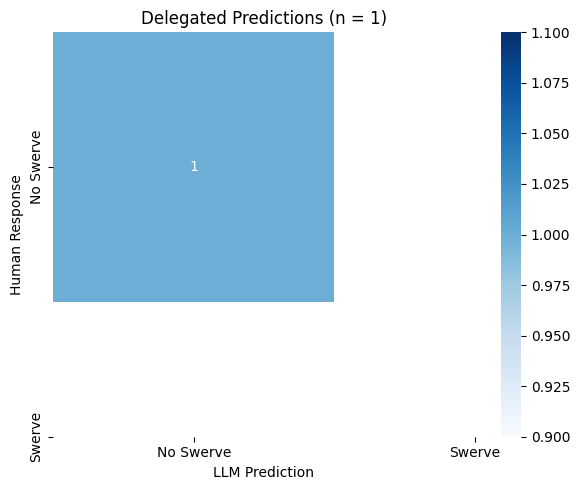

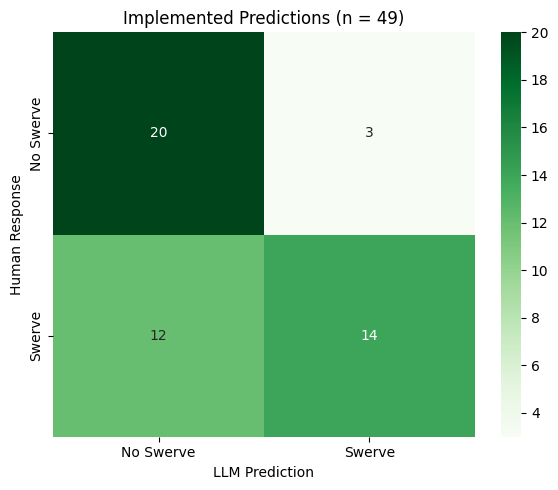

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Coerce types
df_results['llm_prediction'] = df_results['llm_prediction'].astype(str)
df_results['llm_delegate'] = df_results['llm_delegate'].astype(str)
df_results['human_response'] = df_results['human_response'].astype(int)

# Separate based on LLM's delegation choice
df_delegated = df_results[df_results['llm_delegate'] == '1']
df_implemented = df_results[df_results['llm_delegate'] == '0']

# Filter to only valid binary predictions
df_delegated = df_delegated[df_delegated['llm_prediction'].isin(['0', '1'])].copy()
df_implemented = df_implemented[df_implemented['llm_prediction'].isin(['0', '1'])].copy()

# Convert to integers
df_delegated['llm_prediction'] = df_delegated['llm_prediction'].astype(int)
df_implemented['llm_prediction'] = df_implemented['llm_prediction'].astype(int)

# Labels
labels = ["No Swerve", "Swerve"]

# Confusion Matrix: Delegated
num_delegated = len(df_delegated)
if num_delegated > 0:
    cm_delegated = confusion_matrix(df_delegated['human_response'], df_delegated['llm_prediction'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_delegated, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("LLM Prediction")
    plt.ylabel("Human Response")
    plt.title(f"Delegated Predictions (n = {num_delegated})")
    plt.tight_layout()
    plt.show()
else:
    print("No delegated predictions to display.")

# Confusion Matrix: Implemented
num_implemented = len(df_implemented)
if num_implemented > 0:
    cm_implemented = confusion_matrix(df_implemented['human_response'], df_implemented['llm_prediction'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_implemented, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
    plt.xlabel("LLM Prediction")
    plt.ylabel("Human Response")
    plt.title(f"Implemented Predictions (n = {num_implemented})")
    plt.tight_layout()
    plt.show()
else:
    print("No implemented predictions to display.")
